<a href="https://colab.research.google.com/github/JakubWalczykowski/notebooks/blob/main/crimePraca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyspark
!pip install -U statsmodels

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')
from statsmodels.tsa.holtwinters import ExponentialSmoothing


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ###-----
# df1 = pd.read_csv('/content/drive/MyDrive/crime/Crimes_-_2001_to_Present_20240311.csv')
# #df2 = pd.read_csv('/content/drive/MyDrive/crime/Chicago_Population_Counts_20240301.csv')
# df2 = pd.read_csv('/content/drive/MyDrive/crime/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012_20240301.csv')
# df3 = pd.read_csv('/content/drive/MyDrive/crime/Census_Data_-_Languages_spoken_in_Chicago__2008___2012_20240301.csv')
# df4 = pd.read_csv('/content/drive/MyDrive/crime/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical_20240301.csv')

# ####




In [ ]:
#df1.head()

In [ ]:
#df2.head()

In [ ]:
#df3.head()

In [ ]:
#df4.head()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import asc
from pyspark.sql.functions import to_date, to_timestamp, date_format
from pyspark.sql.functions import year, month, count
from pyspark.sql.functions import year, month, concat_ws


spark = SparkSession.builder \
    .appName("Join CSV Files") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [ ]:
df1 = spark.read.csv('/content/drive/MyDrive/crime/Crimes_-_2001_to_Present_20240311.csv', header=True, inferSchema=True)
#df2 = spark.read.csv('/content/drive/MyDrive/crime/Chicago_Population_Counts_20240301.csv', header=True, inferSchema=True)
df2 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Languages_spoken_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df4 = spark.read.csv('/content/drive/MyDrive/crime/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical_20240301.csv', header=True, inferSchema=True)

In [ ]:
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
df2.printSchema()

root
 |-- Community Area Number: integer (nullable = true)
 |-- COMMUNITY AREA NAME: string (nullable = true)
 |-- PERCENT OF HOUSING CROWDED: double (nullable = true)
 |-- PERCENT HOUSEHOLDS BELOW POVERTY: double (nullable = true)
 |-- PERCENT AGED 16+ UNEMPLOYED: double (nullable = true)
 |-- PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA: double (nullable = true)
 |-- PERCENT AGED UNDER 18 OR OVER 64: double (nullable = true)
 |-- PER CAPITA INCOME : integer (nullable = true)
 |-- HARDSHIP INDEX: integer (nullable = true)



In [ ]:
df3.printSchema()

root
 |-- Community Area: integer (nullable = true)
 |-- Community Area Name: string (nullable = true)
 |-- PREDOMINANT NON-ENGLISH LANGUAGE (%): string (nullable = true)
 |-- AFRICAN LANGUAGES: integer (nullable = true)
 |-- ARABIC: integer (nullable = true)
 |-- ARMENIAN: integer (nullable = true)
 |-- CAMBODIAN (MON-KHMER): integer (nullable = true)
 |-- CHINESE: integer (nullable = true)
 |-- CREOLE: integer (nullable = true)
 |-- FRENCH: integer (nullable = true)
 |-- GERMAN: integer (nullable = true)
 |-- GREEK: integer (nullable = true)
 |-- GUJARATI: integer (nullable = true)
 |-- HEBREW: integer (nullable = true)
 |-- HINDI: integer (nullable = true)
 |-- HMONG: integer (nullable = true)
 |-- HUNGARIAN: integer (nullable = true)
 |-- ITALIAN: integer (nullable = true)
 |-- JAPANESE: integer (nullable = true)
 |-- KOREAN: integer (nullable = true)
 |-- LAOTIAN: integer (nullable = true)
 |-- NAVAJO: integer (nullable = true)
 |-- OTHER ASIAN: integer (nullable = true)
 |-- OTHE

In [ ]:
df4.printSchema()

root
 |-- Community Area: integer (nullable = true)
 |-- Community Area Name: string (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- General Fertility Rate: double (nullable = true)
 |-- Low Birth Weight: double (nullable = true)
 |-- Prenatal Care Beginning in First Trimester: double (nullable = true)
 |-- Preterm Births: double (nullable = true)
 |-- Teen Birth Rate: double (nullable = true)
 |-- Assault (Homicide): double (nullable = true)
 |-- Breast cancer in females: double (nullable = true)
 |-- Cancer (All Sites): double (nullable = true)
 |-- Colorectal Cancer: double (nullable = true)
 |-- Diabetes-related: double (nullable = true)
 |-- Firearm-related: double (nullable = true)
 |-- Infant Mortality Rate: double (nullable = true)
 |-- Lung Cancer: double (nullable = true)
 |-- Prostate Cancer in Males: double (nullable = true)
 |-- Stroke (Cerebrovascular Disease): double (nullable = true)
 |-- Childhood Blood Lead Level Screening: double (nullable = true)
 |

In [ ]:
df2 = df2.withColumnRenamed("Community Area Number", "Community Area")

In [ ]:
df2.printSchema()

root
 |-- Community Area: integer (nullable = true)
 |-- COMMUNITY AREA NAME: string (nullable = true)
 |-- PERCENT OF HOUSING CROWDED: double (nullable = true)
 |-- PERCENT HOUSEHOLDS BELOW POVERTY: double (nullable = true)
 |-- PERCENT AGED 16+ UNEMPLOYED: double (nullable = true)
 |-- PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA: double (nullable = true)
 |-- PERCENT AGED UNDER 18 OR OVER 64: double (nullable = true)
 |-- PER CAPITA INCOME : integer (nullable = true)
 |-- HARDSHIP INDEX: integer (nullable = true)



In [ ]:
joined_df = df1.join(df2, ["Community Area"]).drop(col("COMMUNITY AREA NAME"))
joined_df = joined_df.join(df3, ["Community Area"]).drop(col("Community Area Name"))
joined_df = joined_df.join(df4, ["Community Area"])
joined_df.printSchema()


root
 |-- Community Area: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- PERCENT OF HOUSING CROWDED: double (nullable = true)
 |-- PERCENT HOUSEHOLDS BELOW POVERTY: 

In [ ]:
joined_df = joined_df.withColumn('Date', to_timestamp(joined_df['Date'], 'MM/dd/yyyy hh:mm:ss a'))


# Create new columns for date and time
joined_df = joined_df.withColumn('Date_only', to_date(joined_df['Date']))
joined_df = joined_df.withColumn('Time_only', date_format(joined_df['Date'], 'HH:mm:ss'))


df = joined_df.orderBy('Date', ascending=True)


In [ ]:
#df.show(30)

In [ ]:
from pyspark.sql.functions import year, month, concat_ws
df = df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
df = df.withColumn("YearMonth", concat_ws("-", df["Year"], df["Month"]))
df = df.withColumn("YearMonth", to_date(df["YearMonth"], "yyyy-MM"))
#grouped_df = df.groupBy("YearMonth", df["Year"], df["Month"]).agg(count("*").alias("Count")).orderBy("YearMonth")
grouped_df = df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
#grouped_df.show()

In [ ]:
grouped_df.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- YearMonth: date (nullable = true)
 |-- Count: integer (nullable = false)



In [ ]:
#grouped_df.show(150)

In [ ]:
######beanchmark start----

pd_df = grouped_df.toPandas()

fig = px.bar(pd_df, x='YearMonth', y='Count', title='Count of Events per Year-Month')

# Show the plot
fig.show()

In [ ]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       279 non-null    int32 
 1   Month      279 non-null    int32 
 2   YearMonth  279 non-null    object
 3   Count      279 non-null    int32 
dtypes: int32(3), object(1)
memory usage: 5.6+ KB


In [ ]:
pd_df.set_index('YearMonth', inplace=True)
pd_df = pd_df.drop(pd_df.index[:24])
pd_df = pd_df.drop(pd_df.index[-1])
df=pd_df.drop(['Year', 'Month'], axis=1)
df.head()


,Count
YearMonth,
2003-01-01,36721
2003-02-01,32508
2003-03-01,38646
2003-04-01,39783
2003-05-01,41188


In [ ]:
df_reset = df.reset_index()

# Plot using Plotly Express
fig = px.bar(df_reset, x='YearMonth', y='Count', title='Count of Events per Year-Month')

# Show or save the plot
fig.show()

In [ ]:
df.head()

,Count
YearMonth,
2003-01-01,36721
2003-02-01,32508
2003-03-01,38646
2003-04-01,39783
2003-05-01,41188


In [ ]:
#df.info()

In [ ]:
#df.plot();

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



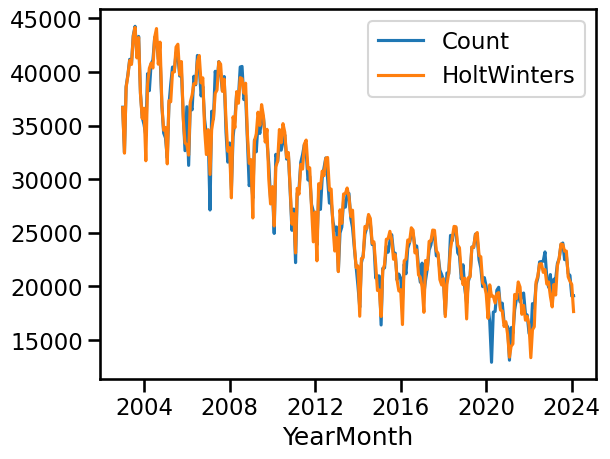

In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

hw = ExponentialSmoothing(
    train['Count'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()



df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Count', 'HoltWinters']].plot();



In [ ]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

def mae(y, t):
  return np.mean(np.abs(y - t))

print("Train RMSE:", rmse(train['Count'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Count'], res_hw.forecast(N_test)))



Train RMSE: 1111.4157842434338
Test RMSE: 765.1268886262785


In [ ]:
print("Train MAE:", mae(train['Count'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Count'], res_hw.forecast(N_test)))



Train MAE: 811.6171251565022
Test MAE: 583.4637613343606


In [ ]:
#####end of beanchmark

In [ ]:
grouped_df.printSchema()


root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- YearMonth: date (nullable = true)
 |-- Count: integer (nullable = false)



Text(0.5, 0, 'Time')

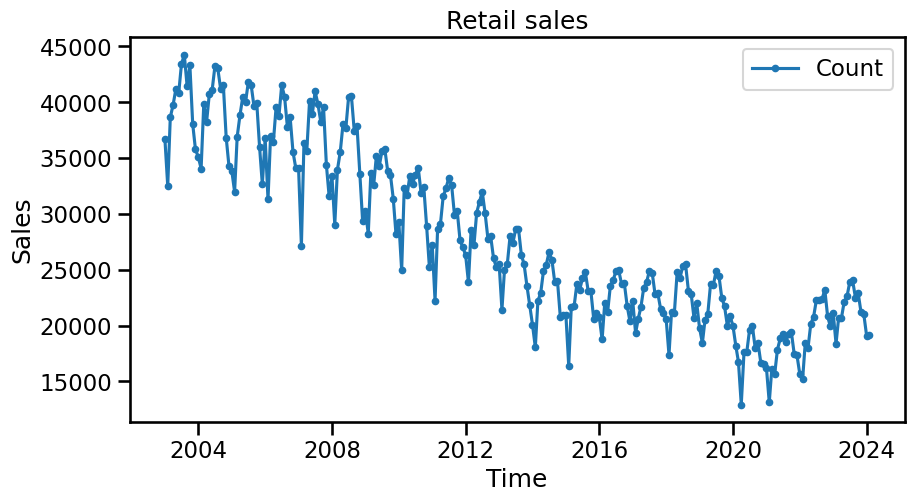

In [ ]:
grouped_df = grouped_df.toPandas()
grouped_df.set_index('YearMonth', inplace=True)
grouped_df = grouped_df.drop(grouped_df.index[:24])
grouped_df = grouped_df.drop(grouped_df.index[-1])
df1=grouped_df.drop(['Year', 'Month'], axis=1)




sns.set_context("talk")



ax = df1.plot(y="Count", marker=".", figsize=[10, 5])
ax.set_title('Retail sales')
ax.set_ylabel('Sales')
ax.set_xlabel('Time')

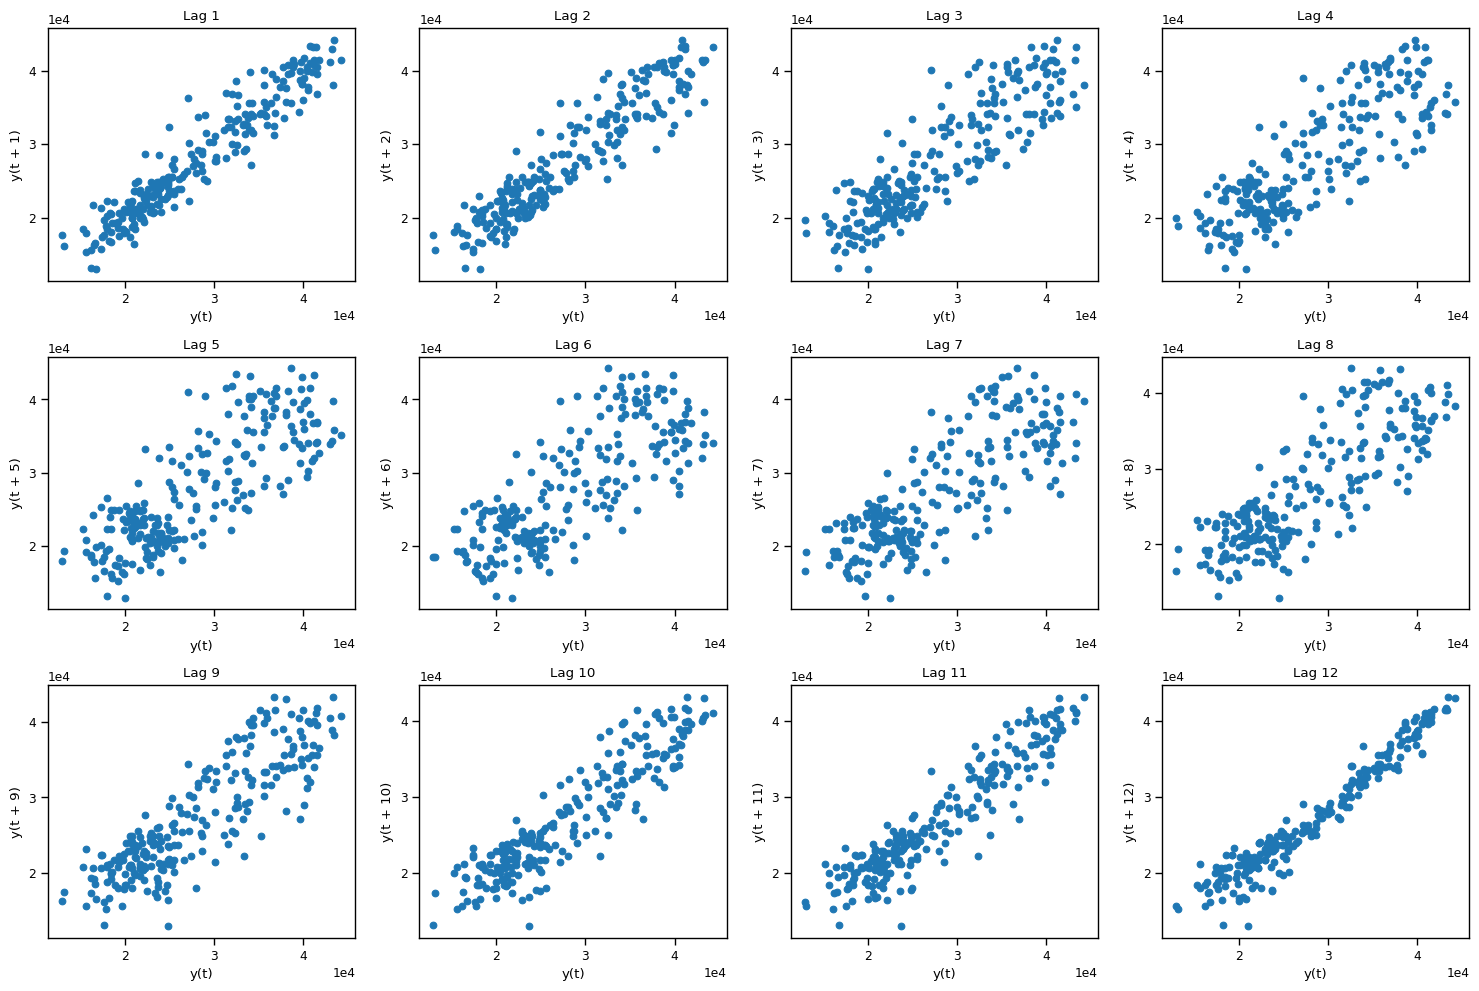

In [ ]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=[15, 10])
    for i, ax_ in enumerate(ax.flatten()):
        pd.plotting.lag_plot(df1["Count"], lag=i + 1, ax=ax_)
        ax_.set_title(f"Lag {i+1}")
        ax_.ticklabel_format(style="sci", scilimits=(0, 0))
    plt.tight_layout()

In [ ]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 2003-01-01 to 2024-02-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    254 non-null    int32
 1   Month   254 non-null    int32
 2   Count   254 non-null    int32
dtypes: int32(3)
memory usage: 5.0+ KB


In [ ]:
grouped_df["Month_sin"] = np.sin(grouped_df["Month"] / grouped_df["Month"].max() * 2 * np.pi)

grouped_df["Month_cos"] = np.cos(grouped_df["Month"] / grouped_df["Month"].max() * 2 * np.pi)
grouped_df.drop(['Month'], axis=1)

grouped_df['lag_1'] = grouped_df['Count'].shift(1)
grouped_df['lag_12'] = grouped_df['Count'].shift(12)

In [ ]:
grouped_df.head(20)

,Year,Month,Count,Month_sin,Month_cos,lag_1,lag_12
YearMonth,,,,,,,
2003-01-01,2003,1,36721,5.000000e-01,8.660254e-01,NaN,NaN
2003-02-01,2003,2,32508,8.660254e-01,5.000000e-01,36721.0,NaN
2003-03-01,2003,3,38646,1.000000e+00,6.123234e-17,32508.0,NaN
2003-04-01,2003,4,39783,8.660254e-01,-5.000000e-01,38646.0,NaN
2003-05-01,2003,5,41188,5.000000e-01,-8.660254e-01,39783.0,NaN
2003-06-01,2003,6,40813,1.224647e-16,-1.000000e+00,41188.0,NaN
2003-07-01,2003,7,43415,-5.000000e-01,-8.660254e-01,40813.0,NaN
2003-08-01,2003,8,44270,-8.660254e-01,-5.000000e-01,43415.0,NaN
2003-09-01,2003,9,41424,-1.000000e+00,-1.836970e-16,44270.0,NaN


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


In [ ]:
holdout_size = 12
df_train = grouped_df.iloc[:-holdout_size]
df_test = grouped_df.iloc[-holdout_size:]




features = ["Year","Month_sin","Month_cos","lag_1","lag_12"]
target = ["Count"]

y_train = df_train[target]
X_train = df_train[features]

y_test = df_test[target]
X_test = df_test[features]

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")



AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/data/mllib/sample_libsvm_data.txt.

In [ ]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [ ]:

# Train a GBT model.
gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)



In [ ]:

# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, gbt])

In [ ]:
# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

In [ ]:

# Make predictions.
predictions = model.transform(testData)


In [ ]:

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:

gbtModel = model.stages[1]
print(gbtModel)  # summary only